# Objective - ABANDONED

Similar to [variance_map_ps_imp_I.ipynb](variance_map_ps_imp_I.ipynb), but now trying to get I, Q, and U noise maps. To be followed with implemention of the method given in Appendix A of Planck CO Revisited (Ghosh, S., et al.: A&A, 688, A54).

Retaining because it contains a trace of the IQU stuff. More recently I outlined a method with Yunan for how this could be done for IQU noise:

- White Anisotropic Noise
    - Load II, QQ, UU variance maps; generate anisotropic white noise for each
    - Get all alms almT, almE, almB (map2alm handles this for sequence of arrays)
    - Get all power spectra: TT, TE, TB, EE, EB, BB (alm2cl handles this for sequence of arrays)
- Target Correlated Noise
    - Load Planck noise simulations
    - Get all power spectra: TT, TE, TB, EE, EB, BB (anafast handles this for sequence of arrays)
    - (Show all PS on same plot; are they the same scale?)
    - Stack all power spectra into single vector
    - Get PCA representation of log of that
    - At simulation time, draw random realization using this, convert back to 6 arrays
- Make filter
    - For each array, filter is sqrt(target/white)
    - Create array of all ones, shaped $3\times \ell_{max}$
    - Reshape filter to be 3x3 covariance matrix
    - Apply that to array of all ones --> we have array of filters for almT, almE, almB
    - Apply filters individually

# Imports and Parameters

In [14]:
from pathlib import Path

import numpy as np
import healpy as hp
# from scipy.stats import ks_2samp
import torch

import matplotlib.pyplot as plt
from tqdm import tqdm

from handle_data import get_map_dtype, get_planck_obs_data, get_planck_noise_data

In [ ]:
hp.almxfl()

In [15]:
DATA_ROOT = "/data/jim/CMB_Data/"
ASSETS_DIRECTORY = f"{DATA_ROOT}/Assets/Planck/"
PLANCK_NOISE_DIR = f"{DATA_ROOT}/Planck_Noise/"

DETECTOR = 100
RANDOM_SEED = 42
PLANCK_SIM_NUM = 0
SMOOTHING = 10 / 60  # 10 arcminutes (in degrees)

In [16]:
def get_lmax_for_nside(nside):
    """Helper function: Max ell for a given nside; to be considered a parameter"""
    return 2 * nside

# Display PS Helpers

In [17]:
def plot_ps(ps,
            title=None, 
            x_low=1,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    plt.plot(ps)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    plt.show()

In [18]:
def plot_many_ps(ps_s,
            title=None, 
            x_low=1,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            labels=None):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    for i, ps in enumerate(ps_s):
        label = None if labels is None else labels[i]
        plt.plot(ps, label=label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    plt.legend()
    plt.show()

# Creating a Noise Map at $N_{side}=2048$

We try to generate white anisotropic noise, correlated across I, Q, and U fields, per the variance data in the observation maps.

In [13]:
obs_map_fn = get_planck_obs_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY)
use_nside_out = 2048

File /data/jim/CMB_Data/Assets/Planck/HFI_SkyMap_100_2048_R3.01_full.fits exists.


In [19]:
# Load the source map from Planck
planck_obs_path = Path(ASSETS_DIRECTORY) / obs_map_fn
II_cov_field = 4
IQ_cov_field = 5
IU_cov_field = 6
QI_cov_field = 7
QU_cov_field = 8
UU_cov_field = 9
cov_maps = hp.read_map(planck_obs_path, hdu=1, field=[4,5,6,7,8,9])
assert use_nside_out == hp.get_nside(cov_maps[0])  # Make sure we're using the right nside

In [36]:
c00 = cov_maps[0]
c01 = cov_maps[1]
c02 = cov_maps[2]
c11 = cov_maps[3]
c12 = cov_maps[4]
c22 = cov_maps[5]

cov_matrices = np.array([[c00, c01, c02],
                         [c01, c11, c12],
                         [c02, c12, c22]])

print(cov_matrices.shape)

(3, 3, 50331648)


In [37]:
npix = hp.nside2npix(use_nside_out)
assert npix == cov_matrices.shape[2]  # Ensure that there is a covariance matrice for each pixel

In [52]:
for i in range(npix):
    e_v, e_ve = np.linalg.eigh(cov_matrices[:,:,i])

In [38]:
cholesky_matrices = np.zeros_like(cov_matrices)
for i in tqdm(range(npix)):
    try:
        maybe = np.linalg.cholesky(cov_matrices[:,:,i])
        cholesky_matrices[:,:,i] = maybe
    except np.linalg.LinAlgError as e:
        print(f"Error at pixel {i}: {e} - {cov_matrices[:,:,i]}")

 91%|█████████ | 45596663/50331648 [04:54<00:32, 143753.52it/s]

Error at pixel 45581992: Matrix is not positive definite - [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


100%|██████████| 50331648/50331648 [05:26<00:00, 153992.63it/s]


In [49]:
cov_matrices_torch = torch.tensor(cov_matrices).to('cpu')

We're going to get the Cholesky decomposition of the covariance matrices, so we can shape a uniform gaussian field (in the pixel domain) to match the expected distribution.

In [50]:
# Apparently, some covariance matrices are not positive definite; this will create issues with the Cholesky decomposition
e_vals, e_vecs = torch.linalg.eigh(cov_matrices_torch.permute(2,0,1))
issue_pixels = e_vals.min(dim=-1).values <= 0  # Shape (Npix,)

In [41]:
# Count the number of problematic pixels
count_problematic = issue_pixels.sum().item()

# Find the indices of problematic pixels
problematic_indices = torch.nonzero(issue_pixels, as_tuple=True)[0]

print(f"Number of problematic pixels: {count_problematic}")
print(f"Indices of problematic pixels: {problematic_indices}")

Number of problematic pixels: 1
Indices of problematic pixels: tensor([45581992])


In [45]:
abs_cov = torch.abs(cov_matrices_torch)
abs_cov[abs_cov == 0] = float('inf')
min_cov = abs_cov.min().item()
min_cov

1.1362227340283518e-18

In [34]:
cholesky_matrices_torch = torch.linalg.cholesky(cov_matrices.permute(2,0,1)).permute(1,2,0)

/tmp/ipykernel_3574349/3326980739.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov_matrices_torch = torch.tensor(cov_matrices)


_LinAlgError: linalg.cholesky: (Batch element 45581992): The factorization could not be completed because the input is not positive-definite (the leading minor of order 1 is not positive-definite).

In [8]:

# # Create a "scale factor" map for the noise
# scale_map = np.sqrt(II_cov_map)  # II_cov_map contains variance values; we need standard deviation for rng.normal()
# scale_map = scale_map * 1e6  # convert to uK_CMB

In [9]:
# # Generate the random noise map; calculate its power spectrum
# rng = np.random.default_rng(RANDOM_SEED)
# wht_map = rng.normal(size=scale_map.shape) * scale_map

# lmax_2048 = get_lmax_for_nside(use_nside_out)  # Defined above as 3*Nside-1
# ells_2048 = np.arange(lmax_2048 + 1)
# wht_cl = hp.anafast(wht_map, lmax=lmax_2048)

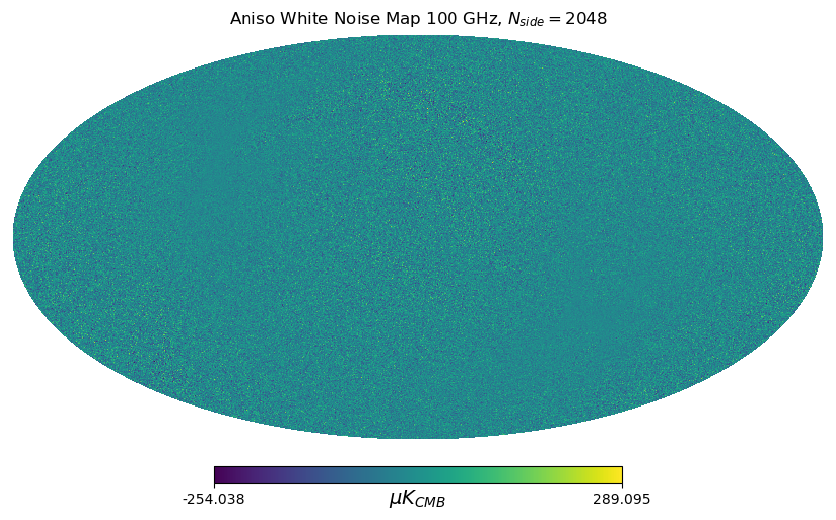

In [10]:
# hp.mollview(wht_map, unit="$\\mu K_{CMB}$", 
#             title="Aniso White Noise Map" + f" {DETECTOR} GHz, " + "$N_{side}" + f"={use_nside_out}$")

In [11]:
# assert hp.npix2nside(wht_map.shape[0]) == 2048
# print(f"We confirm that the map is resolution {hp.npix2nside(wht_map.shape[0])}")

We confirm that the map is resolution 2048


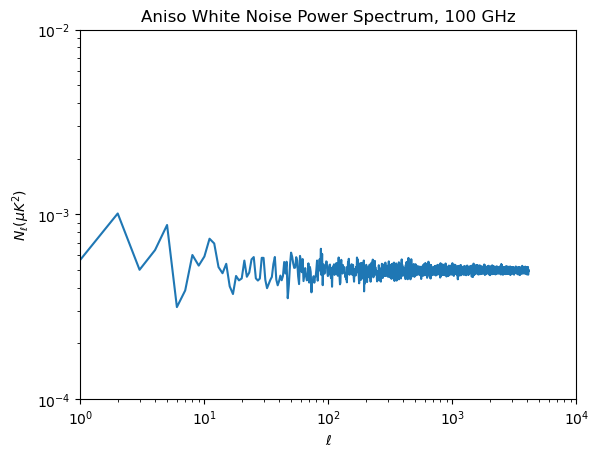

In [12]:
# # Add the white noise level line to the plot; see if it matches expectations
# plot_ps(wht_cl, title=f"Aniso White Noise Power Spectrum, {DETECTOR} GHz")

It looks like white noise at roughly 1e-4 $\mu K^2$.

# Getting Power Spectrum of Sim Noise

I'm trying this out first. It seems like I should be able to apply the method to a single map, as opposed to 5 maps simultaneously. I'm unsure about that though, as the result is not what I'd like.

Method (from Appendix A):
- Get simulation (Sim) with correct anisotropy (not listed as a step in Appendix A)
- Step 1: Generate white noise temperature map (WhT) as above
- Step 2: Smooth WhT to 10' in alm space (WAS)
- Step 3: Compute Cl^TT of WAS (WCl)
- Step 4: Compute Cl^TT of Sim (SCl)
- Step 5: Multiply WAS by SCl^{1/2} * WCl^{-1/2} (element-wise, since these are vectors?)
    - Tried with and without boxcar filter

In [13]:
# # Step 0
# nse_map_fn = get_planck_noise_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY, realization=PLANCK_SIM_NUM)
# nse_map = hp.read_map(nse_map_fn) * 1e6
# nse_map.shape

File /data/jim/CMB_Data/Assets/Planck/ffp10_noise_100_full_map_mc_00000.fits exists.


(50331648,)

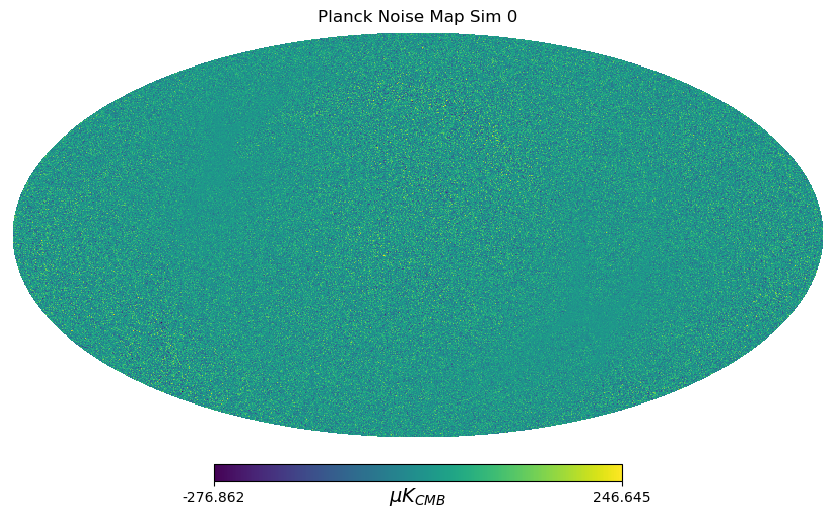

In [14]:
# # Plot the loaded map, to ensure there's nothing goofy going on
# hp.mollview(nse_map, unit="$\\mu K_{CMB}$", title=f"Planck Noise Map Sim {PLANCK_SIM_NUM}")

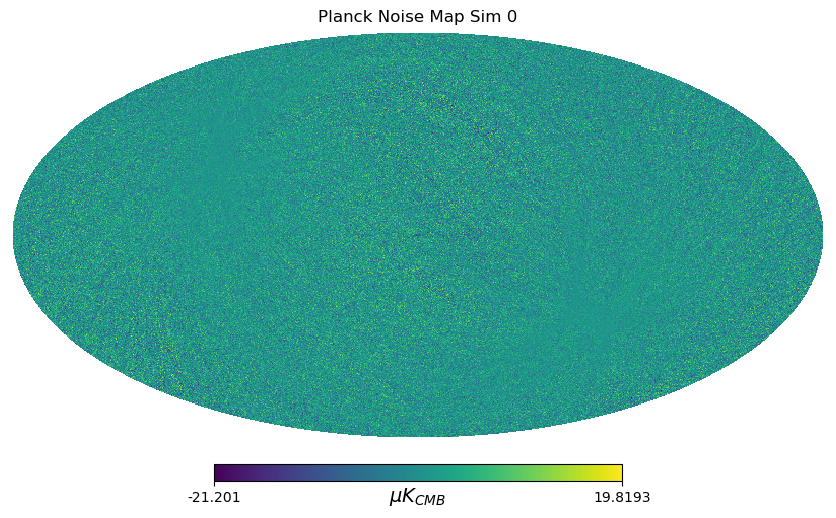

In [15]:
# # Plot it again, this time smoothed, as this matches what we're trying to produce.
# hp.mollview(hp.smoothing(nse_map, fwhm=np.deg2rad(SMOOTHING)), unit="$\\mu K_{CMB}$", title=f"Planck Noise Map Sim {PLANCK_SIM_NUM}")

In [16]:
# Step 1: Get white noise map - Done above in previous section
#         (Cell is deliberately empty)

In [17]:
# # Step 2: Smooth white noise map in alm domain
# wht_alm = hp.map2alm(wht_map, lmax=lmax_2048)
# wht_alm_s = hp.smoothalm(wht_alm, fwhm=np.radians(SMOOTHING))

In [18]:
# # Step 3: Get PS of smoothed white noise map
# wht_cl_s = hp.alm2cl(wht_alm_s, lmax=lmax_2048, lmax_out=lmax_2048)

In [19]:
# # Step 4: Get PS of simulated map
# nse_alm = hp.map2alm(nse_map, lmax=lmax_2048)
# nse_alm_s = hp.smoothalm(nse_alm, fwhm=np.radians(SMOOTHING), inplace=False)
# nse_cl = hp.alm2cl(nse_alm)  # This is for curiosity's sake
# nse_cl_s = hp.alm2cl(nse_alm_s)

In [20]:
# # Step 5: Create filter, mulitply alms by filter
# my_filter = np.sqrt(nse_cl_s / wht_cl_s)
# boxcar = np.ones(10)
# my_filter_bc = np.convolve(my_filter, boxcar, mode='same') / np.sum(boxcar)
# out_alm = hp.almxfl(nse_alm_s, my_filter_bc)

In [21]:
# out_map = hp.alm2map(out_alm, nside=use_nside_out, lmax=lmax_2048)

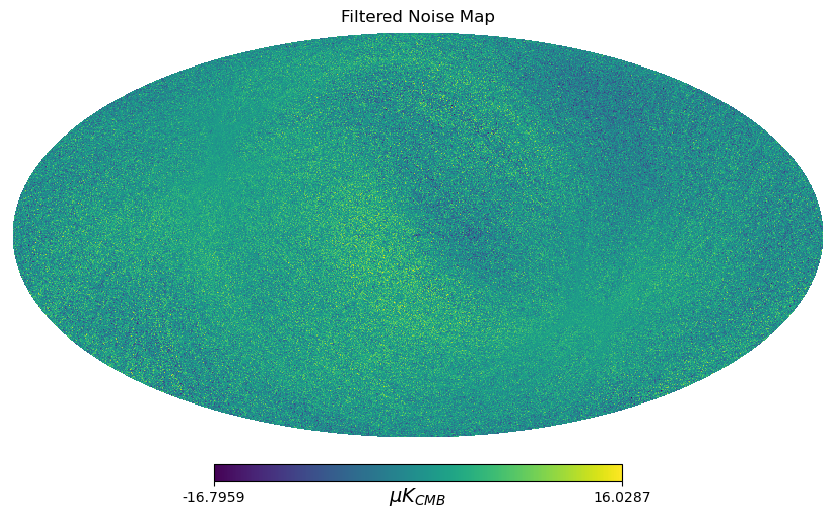

In [22]:
# hp.mollview(out_map, unit="$\\mu K_{CMB}$", title="Filtered Noise Map")

In [23]:
# out_map2ps = hp.anafast(out_map, lmax=lmax_2048)

In [53]:
# plot_many_ps([
#               nse_cl_s, 
#               wht_cl_s, 
#               out_map2ps
#               ], 
#               labels=[
#                   "Planck", 
#                   "White", 
#                   "Output"
#                   ], 
#               title="Simulated Noise vs Smoothed Noise")